In [1]:
import random
x = random.uniform(0,1)

In [2]:
x

0.18026306747042942

In [157]:
import pandas as pd
import numpy as np
import datetime

from sklearn.cross_validation import LeaveOneOut
from sklearn.grid_search import (GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import (mean_squared_error, mean_absolute_error)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier # Used for imputing rare / missing values

# Regressors considered:
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge # only model used for final submission
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [158]:
# Kaggle added approximately 311.5 "fake" data points to the test for each real data point. 
# Dividing by this number gives more accurate counts of the "real" data in the test set.
FAKE_DATA_RATIO = 311.5
# Set a Random Seed
SEED = 0
# Read Kaggle Provided Data
train = pd.read_csv('train.csv', index_col = 0, parse_dates=[1])
test = pd.read_csv('test.csv', index_col = 0, parse_dates=[1])
print "Train Dimensions:"
print train.shape
print "Test Dimensions:"
print test.shape

# Concatenate train and test together to pre-process and featurize both consistently.
df = pd.concat((test, train), ignore_index=True)
df.describe()

Train Dimensions:
(137, 42)
Test Dimensions:
(100000, 41)


,P1,P10,P11,P12,P13,P14,P15,P16,P17,P18,...,P35,P36,P37,P4,P5,P6,P7,P8,P9,revenue
count,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,...,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,137.000000
mean,4.087930,5.459011,3.311653,5.061765,5.086621,1.280276,1.305641,1.747336,1.156715,1.708789,...,1.833099,1.969222,0.973696,4.395992,1.989614,2.882551,5.300678,4.931304,5.251645,4453532.613139
std,2.813085,1.763709,2.067903,1.765647,0.979414,2.497106,2.167272,3.172481,2.432137,3.030907,...,3.229052,3.806280,1.677427,1.035796,1.065518,1.532502,2.178739,1.718699,1.702825,2576071.595708
min,1.000000,4.000000,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1149870.000000
25%,2.000000,5.000000,2.000000,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,2999068.000000
50%,3.000000,5.000000,3.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,2.000000,2.000000,5.000000,5.000000,5.000000,3939804.000000
75%,4.000000,5.000000,4.000000,5.000000,5.000000,2.000000,2.000000,3.000000,2.000000,4.000000,...,4.000000,3.000000,2.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,5166635.000000
max,15.000000,10.000000,10.000000,10.000000,7.500000,15.000000,10.000000,15.000000,15.000000,15.000000,...,15.000000,20.000000,8.000000,7.500000,8.000000,10.000000,10.000000,10.000000,10.000000,19696939.000000


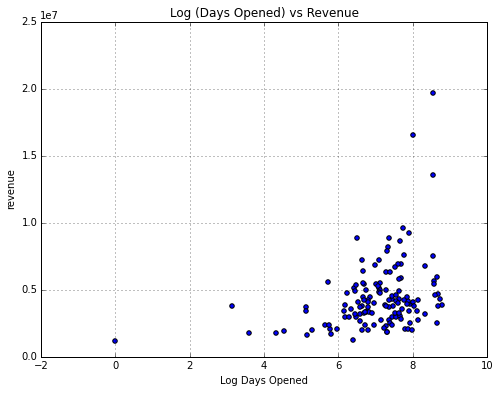

In [159]:
# Convert date strings to "days open" numerical value
df["Open Date"] = df["Open Date"].apply(pd.to_datetime)
last_date = df["Open Date"].max()
df["Open Date"] = last_date - df["Open Date"] # This becomes a datetime delta object
df["Open Date"] = df["Open Date"].dt.days + 1 # converts the delta object to an int

# Scale "days since opened" so that the marginal impact decreases over time
# This and the similar log transform of City Count below are the modifications that 
# were not in our official competition submission
df["Log Days Opened"] = df["Open Date"].apply(np.log)
df = df.drop(["Open Date"], axis=1)
pylab.rcParams['figure.figsize'] = (8, 6) # Resizes plots
df[["Log Days Opened", "revenue"]].plot(x="Log Days Opened", y="revenue", kind='scatter', title="Log (Days Opened) vs Revenue")

Distribution of new Zeros features:


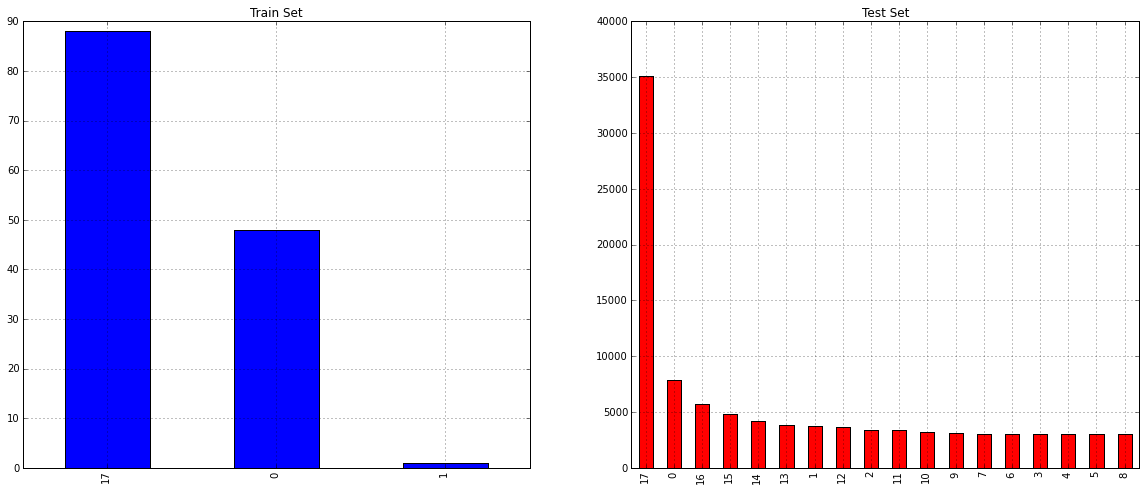

In [160]:
# Lin noticed that a certain set of columns are either all zero or all non-zero.  
# We added a feature to mark this  - The "zeros" feature will be 17 for these rows
# and 0 or 1 for the rows which are never or rarely zero.

# The features with the notable zero behavior:
zero_cols = ['P14', 'P15', 'P16', 'P17', 'P18', 'P24', 'P25', 'P26', 'P27', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37']

# We make a feature that holds this count of zero columns in the above list
df['zeros'] = (df[zero_cols] == 0).sum(1)

pylab.rcParams['figure.figsize'] = (20, 8)
fig, axs = plt.subplots(1,2)

print "Distribution of new Zeros features:"
# We find there is only 1 row with a zero count between 0 and 17 in the train set, 
df['zeros'].ix[pd.notnull(df.revenue)].value_counts().plot(title="Train Set", kind='bar', ax=axs[0])

# But in the test set there are many rows with an intermediate count of zeros. 
# This is probably an artifact of how the fake test data was generated (conditional 
# dependence between columns was not preserved).
df['zeros'].ix[pd.isnull(df.revenue)].value_counts().plot(title="Test Set", kind='bar', ax=axs[1], color='red')
plt.show()

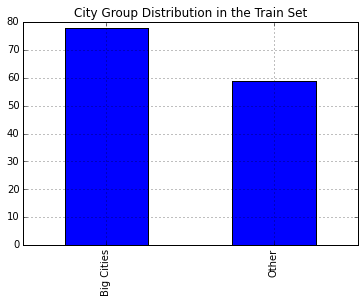

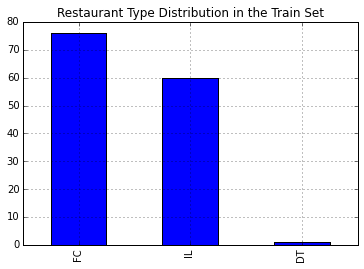

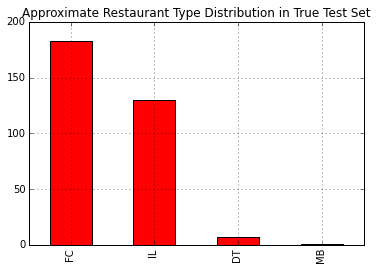

(100137, 44)


In [161]:
# Here we convert two categorical variables, "Restaurant Type" and "City Group (Size)" 
# to dummy variables
pylab.rcParams['figure.figsize'] = (6, 4) # Resizes plots

# The two categories of City Group both appear very frequently
train["City Group"].value_counts().plot(title="City Group Distribution in the Train Set", kind='bar')
plt.show()

# But two of the four Restaurant Types (DT and FC), are extremely rare
train["Type"].value_counts().plot(title="Restaurant Type Distribution in the Train Set", kind='bar')
plt.show()
#######count()是统计案例的次数, 而value_counts()是依据每个value来统计, 生成一个序列
(test["Type"].value_counts() / FAKE_DATA_RATIO).plot(title="Approximate Restaurant Type Distribution in True Test Set", kind='bar', color='Red')
plt.show()

df = df.join(pd.get_dummies(df['City Group'], prefix="CG"))
df = df.join(pd.get_dummies(df['Type'], prefix="T"))

# Since only n-1 columns are needed to binarize n categories, drop one of the new columns.  
# And drop the original columns.
# And also drop the extremely rare restaurant types (which we handleed especially below)
df = df.drop(["City Group", "Type", "CG_Other", "T_MB", "T_DT"], axis=1)
print df.shape

Some example estimated counts of restaurants per city:
Adana             11.070626
Afyonkarahisar     2.062600
Aksaray            2.086677
Amasya             1.000000
Ankara            46.993579
dtype: float64


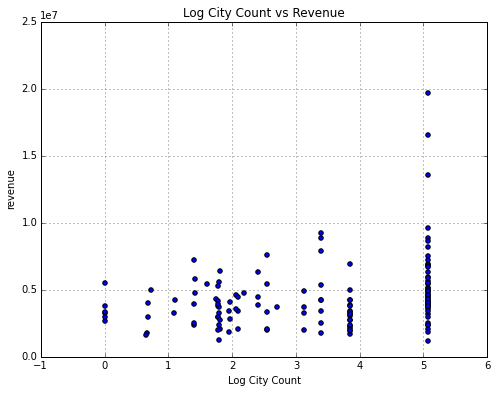

In [162]:
# Replace city names with
# count of their frequency in the train + estimated frequency in the test set.
city_counts = (test["City"].value_counts() / FAKE_DATA_RATIO).add(train["City"].value_counts(), fill_value=0)
df["City"] = df["City"].replace(city_counts)
########replace的参数需为series
print "Some example estimated counts of restaurants per city:"
print city_counts.head()

# Take log of city count so that the marginal effect decreases
df["Log City Count"] = df["City"].apply(np.log) 
df = df.drop(["City"], axis=1)

# That last vertical spread of points are restaurants from Istanbul.
pylab.rcParams['figure.figsize'] = (8, 6) # Resizes plots
df[["Log City Count", "revenue"]].plot(x="Log City Count", y="revenue", kind='scatter', title="Log City Count vs Revenue")
########注意上面df正确把多个序列添加到现有数据框的方式

In [163]:
# Impute values for the very rare restaurant types. 
# Instead of trying to predict with values that appear only 1 or 0 times in the train set, 
# we will replace them with one of the other commonly appearing categories by fitting a 
# model that predicts which common category they "should" be.

# tofit are the rows in the train set that belong to one of the common restaurnat types
tofit = df.ix[((df.T_FC==1) | (df.T_IL==1)) & (pd.notnull(df.revenue))]
# tofill are rows in either train or test that belong to one of the rare types
tofill = df.ix[((df.T_FC==0) & (df.T_IL==0))]

######把train和test中的T_DT和T_MB变为T_FC或T_IL

print "type training set shape:", tofit.shape
print "data to impute:", tofill.shape

# Resaruants with type FC are labeled 1, those with type IL are labeled 0.
y = tofit.T_FC
# Drop the label columns and revenue (which is not in the test set, so can't be used here)
X = tofit.drop(["T_FC", "T_IL", "revenue"], axis=1)

######drop掉FC因为FC为predict项, revenue在test中不存在

type training set shape: (136, 44)
data to impute: (2535, 44)


In [183]:
tofill

,P1,P10,P11,P12,P13,P14,P15,P16,P17,P18,...,P7,P8,P9,revenue,Log Days Opened,zeros,CG_Big Cities,T_FC,T_IL,Log City Count
35,12,8,2,6,5.0,0,0,0,0,0,...,5,8,8,NaN,8.536996,17,0,0,0,2.708692
43,5,4,1,4,4.0,0,0,0,0,5,...,5,5,4,NaN,8.615771,7,1,0,0,5.071596
65,5,4,4,3,4.0,0,0,0,0,0,...,5,4,4,NaN,8.633553,17,1,0,0,5.071596
144,3,5,2,5,5.0,0,0,0,0,0,...,5,4,10,NaN,8.536996,17,0,0,0,2.708692
173,2,5,5,5,5.0,0,0,0,0,0,...,5,2,4,NaN,8.536996,17,1,0,0,5.071596
267,4,5,3,4,5.0,0,0,0,0,0,...,5,4,4,NaN,8.497195,17,1,0,0,5.071596
276,5,4,5,3,4.0,5,4,0,2,5,...,5,5,8,NaN,7.862112,9,1,0,0,5.071596
351,4,5,3,4,5.0,0,0,0,0,0,...,5,4,4,NaN,8.497195,17,0,0,0,1.972832
355,4,4,2,5,4.0,3,5,2,4,4,...,5,5,5,NaN,5.929589,1,0,0,0,2.186826
364,2,4,3,3,5.0,0,0,0,0,0,...,5,4,4,NaN,7.665753,14,1,0,0,5.071596


In [165]:
# Define and train a model to impute restaurant type
# The grid below just has a range of values that I've found commonly
# work well with random forest type models (of which ExtraTrees is one).

#######训练一个模型, 用来替换T_DT和T_MB

model_grid = {'max_depth': [None, 8], 'min_samples_split': [4,9,16], 'min_samples_leaf':[1,4], 'max_features':['sqrt', 0.5, None]}
type_model = ExtraTreesClassifier(n_estimators=25, random_state=SEED)

grid = RandomizedSearchCV(type_model, model_grid, n_iter=10, cv=5, scoring="roc_auc")
grid.fit(X, y)

#######fit的是tofit表

print("Best parameters for Type Model:")
print(grid.best_params_)

type_model.set_params(**grid.best_params_)
type_model.fit(X, y)

imputations = type_model.predict(tofill.drop(["T_FC", "T_IL", "revenue"], axis=1))
df.loc[(df.T_FC==0) & (df.T_IL==0), "T_FC"] = imputations
df = df.drop(["T_IL"], axis=1)

#######当列FC和列IL都不为0的地方必然是MB和DT, 填充这个地方. 也就是将MB和TD出现的地方换为IL和FC. 再drop掉IL, 这样T系列就只有一个列表示

print "% labeled FC in the training set:", df.T_FC.mean()
print "% of imputed values labeled FC:", np.mean(imputations)

Best parameters for Type Model:
{'max_features': None, 'min_samples_split': 16, 'max_depth': None, 'min_samples_leaf': 1}
% labeled FC in the training set: 0.587904570738
% of imputed values labeled FC: 0.700591715976


In [170]:
imputations

array([ 1.,  0.,  1., ...,  1.,  1.,  1.])

In [173]:
df.columns

Index([u'P1', u'P10', u'P11', u'P12', u'P13', u'P14', u'P15', u'P16', u'P17',
       u'P18', u'P19', u'P2', u'P20', u'P21', u'P22', u'P23', u'P24', u'P25',
       u'P26', u'P27', u'P28', u'P29', u'P3', u'P30', u'P31', u'P32', u'P33',
       u'P34', u'P35', u'P36', u'P37', u'P4', u'P5', u'P6', u'P7', u'P8',
       u'P9', u'revenue', u'Log Days Opened', u'zeros', u'CG_Big Cities',
       u'T_FC', u'Log City Count'],
      dtype='object')

In [174]:
# Now binarize the "P" columns with dummy variables

#####把p开头的列全部二项化, 因为p开头的列看起来都是评级,qualitative, 而不是quantitative

print "Pre-binarizing columns:", len(df.columns)
for col in df.columns:
    if col[0] == 'P':
        print col, len(df[col].unique()), "unique values"
        df = df.join(pd.get_dummies(df[col], prefix=col))
        df = df.drop([col, df.columns[-1]], axis=1)
print "Post-binarizing columns:", len(df.columns)

Pre-binarizing columns: 43
P1 9 unique values
P10 4 unique values
P11 8 unique values
P12 7 unique values
P13 5 unique values
P14 10 unique values
P15 9 unique values
P16 10 unique values
P17 10 unique values
P18 9 unique values
P19 9 unique values
P2 9 unique values
P20 9 unique values
P21 9 unique values
P22 5 unique values
P23 9 unique values
P24 9 unique values
P25 9 unique values
P26 10 unique values
P27 10 unique values
P28 9 unique values
P29 8 unique values
P3 8 unique values
P30 10 unique values
P31 10 unique values
P32 10 unique values
P33 7 unique values
P34 11 unique values
P35 8 unique values
P36 10 unique values
P37 8 unique values
P4 7 unique values
P5 7 unique values
P6 8 unique values
P7 7 unique values
P8 8 unique values
P9 5 unique values
Post-binarizing columns: 279


In [175]:
# Scale all input features to between 0 and 1, critical to do this for KNN or SVR models.
min_max_scaler = MinMaxScaler()
# Don't scale the output - drop it temporarily
rev = df.revenue
df = df.drop(['revenue'], axis=1)
######注意这个函数的用法,可以减少代码量
######MinMaxScaler()是把数据scale在0到1之间, 而StandardScalers()是把数据标准正态化. 对于和正态分布很不想的分布最好不要用后者
df = pd.DataFrame(data = min_max_scaler.fit_transform(df), columns = df.columns, index=df.index)
df = df.join(rev)

# Done with preprocessing. Let's take a last look at the data before modeling with it.
df.describe()

,Log Days Opened,zeros,CG_Big Cities,T_FC,Log City Count,P1_1,P1_2,P1_3,P1_4,P1_5,...,P8_3,P8_4,P8_5,P8_6,P8_8,P9_4,P9_5,P9_6,P9_8,revenue
count,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,...,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,100137.000000,137.000000
mean,0.803995,0.658151,0.492825,0.587905,0.632233,0.051989,0.224752,0.228447,0.282912,0.068566,...,0.061745,0.381507,0.393970,0.015888,0.065620,0.351429,0.499396,0.003066,0.065271,4453532.613139
std,0.124607,0.360692,0.499951,0.492215,0.320736,0.222005,0.417421,0.419834,0.450416,0.252716,...,0.240694,0.485759,0.488631,0.125044,0.247618,0.477419,0.500002,0.055285,0.247004,2576071.595708
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1149870.000000
25%,0.735570,0.352941,0.000000,0.000000,0.394308,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2999068.000000
50%,0.822789,0.764706,0.000000,1.000000,0.623604,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3939804.000000
75%,0.886367,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,5166635.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19696939.000000


In [176]:
df

,Log Days Opened,zeros,CG_Big Cities,T_FC,Log City Count,P1_1,P1_2,P1_3,P1_4,P1_5,...,P8_3,P8_4,P8_5,P8_6,P8_8,P9_4,P9_5,P9_6,P9_8,revenue
0,0.793077,0.941176,0,1,0.013630,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,NaN
1,0.787268,1.000000,0,0,0.394308,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,NaN
2,0.507045,1.000000,1,1,0.762641,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,NaN
3,0.631888,0.882353,0,0,0.540878,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,NaN
4,0.587456,1.000000,0,1,0.155237,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,NaN
5,0.874119,1.000000,0,1,0.359094,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,NaN
6,0.855447,0.470588,0,1,0.034415,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,NaN
7,0.451741,0.529412,1,0,0.762641,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,NaN
8,0.898804,0.529412,1,0,1.000000,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,NaN
9,0.747724,0.235294,1,0,1.000000,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,NaN


In [177]:
# Recover original train/train rows based on revenue (which is null for test rows)
train = df.ix[pd.notnull(df.revenue)]
test = df.ix[pd.isnull(df.revenue)].drop(['revenue'], axis=1)

# Scale revenue by sqrt. 
# The purpose is to decrease the influence of the few very large revenue values.
y = train.revenue.apply(np.sqrt)
X = train.drop(["revenue"], axis=1)

In [178]:
# Now define and train a Ridge Regression model. We tested others from the sklearn package:
# SVR, RandomForest, K-nearest Neighbors, but found Ridge consistantly gave the strongest 
# leaderboard results. When training data is small, simplest is often best.
model_grid = [{'normalize': [True, False], 'alpha': np.logspace(0,10)}]
model = Ridge()

# Use a grid search and leave-one-out CV on the train set to find the best regularization parameter to use.
# (might take a minute or two)
grid = GridSearchCV(model, model_grid, cv=LeaveOneOut(len(y)), scoring='mean_squared_error')
grid.fit(X, y)
print("Best parameters set found on development set:")
print(grid.best_params_)

# Re-train on full training set using the best parameters found in the last step.
model.set_params(**grid.best_params_)
model.fit(X, y)

Best parameters set found on development set:
{'normalize': True, 'alpha': 4.0949150623804256}


Ridge(alpha=4.0949150623804256, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=True, solver='auto', tol=0.001)

In [179]:
# Predict on the test set with the trained model.
submission = pd.DataFrame(columns=['Prediction'],index=test.index, data=model.predict(test))
# Convert back to revenue from sqrt(revenue)
submission.Prediction = submission.Prediction.apply(np.square)
# Add required column name for Kaggle's submission parser:
submission.index.name='Id'
# Write out the submission
submission.to_csv("TFI_Ridge.csv")
# Quick sanity check on the submission
submission.describe().astype(int)

,Prediction
count,100000
mean,4306108
std,644275
min,2180202
25%,3880536
50%,4246704
75%,4653050
max,8874955


In [180]:
# Revenue from train set for comparison
train[['revenue']].describe().astype(int)

,revenue
count,137
mean,4453532
std,2576071
min,1149870
25%,2999068
50%,3939804
75%,5166635
max,19696939


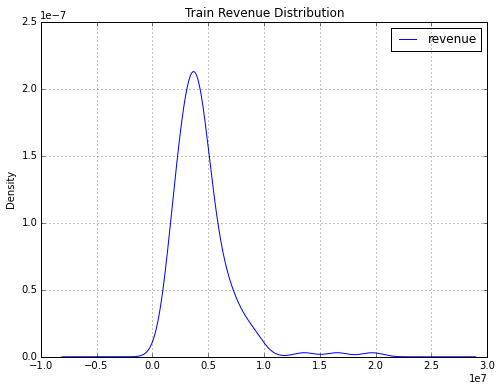

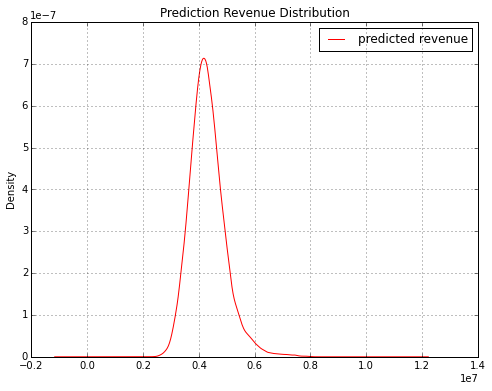

In [181]:
# Another quick comparision. Note the x-axis scale change: the predictions are 
# more conservative and tend to be closer to the mean than the real revenues. 
# This is pretty standard behavior when using RMSE - there are big penalties for 
# being very wrong, so the model will tend towards more moderate predictions.
train[['revenue']].plot(kind='kde', title="Train Revenue Distribution")
submission.columns = ["predicted revenue"]
submission.plot(kind='kde', title="Prediction Revenue Distribution", color='r')
plt.show()